<a href="https://colab.research.google.com/github/bcury/Machine-Learning-Projects/blob/main/ML_Sistemas_Recomenda%C3%A7%C3%B5es_Filmes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Neste kernel,vou  construir um sistema de recomendação de filme de base usando ''TMDB 5000 Movie Dataset''

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
base1 = pd.read_csv('/content/tmdb_5000_credits.csv')

In [3]:
base2 = pd.read_csv('/content/tmdb_5000_movies.csv')

In [4]:
base1.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [5]:
base1.describe()

,movie_id
count,4803.000000
mean,57165.484281
std,88694.614033
min,5.000000
25%,9014.500000
50%,14629.000000
75%,58610.500000
max,459488.000000


In [6]:
base2.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [7]:
base2.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


podemos juntar as colunas ID nos nossos dois datasets

In [8]:
base1.columns = ['id','tittle','cast','crew']
base2 =  base2.merge(base1, on='id')

In [10]:
base2.head(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


agora precisamos usar a equação IMDB's weighted rating (wr), foto da equação esta ao lado, basta clicar

v is the number of votes for the movie;
m is the minimum votes required to be listed in the chart;
R is the average rating of the movie; And
C is the mean vote across the whole report

In [12]:
C = base2['vote_average'].mean()

In [13]:
C

6.092171559442011

In [14]:
m = base2['vote_count'].quantile(0.9)
m

1838.4000000000015


Agora, podemos filtrar os filmes que se qualificam para o gráfico

In [16]:
quali_filmes = base2.copy().loc[base2['vote_count']>=m]


In [17]:
quali_filmes.shape

(481, 23)

temos então 481 filmes que se clasificam nesta lista, agora precisamos calcular as metricas para cada filme qualificado, e para tal, vamos definir uma função weighted_rating(), então, vamos lá:

In [18]:
 def weighted_rating(x, m=m, C=C):
   v = x['vote_count']
   R = x['vote_average']

   return (v/(v+m)*R) + (m/(m+v)*C)

In [19]:
quali_filmes['score'] = quali_filmes.apply(weighted_rating, axis = 1)

agora vou classificar os filmes de acordo com a equação calculada acima

In [20]:
quali_filmes = quali_filmes.sort_values('score', ascending=False)

In [22]:
quali_filmes[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


apesar de básico, já encontramos nosso recomendador de filmes, agora vamos encontrar filmes que são muito populares e podem ser obtidos classificando o conjunto de dados 

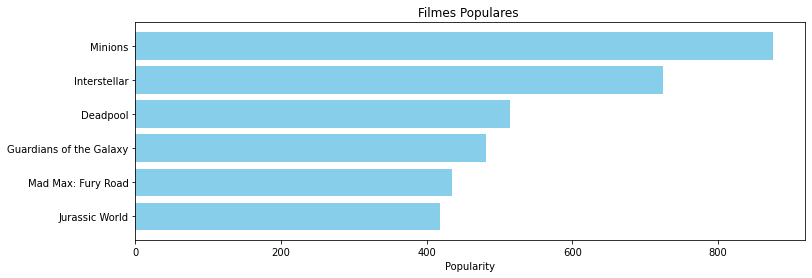

In [28]:
popular = base2.sort_values('popularity', ascending=False)
plt.figure(figsize=(12,4))
plt.barh(popular['title'].head(6),popular['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Filmes Populares ")
plt.show()


algo agora é que esses recomendadores demográficos fornecem um gráfico geral de filmes recomendados para todos os usuários. Eles não são sensíveis aos interesses e gostos de um usuário específico. É quando passamos para um sistema mais refinado - Filtragem de conteúdo básico, vamos lá:

In [29]:
base2['overview'].head(5)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [36]:
tfibase1 = TfidfVectorizer(stop_words='english')

In [37]:
#substituir Nan com uma string vazia
base2['overview'].fillna('')

0       In the 22nd century, a paraplegic Marine is di...
1       Captain Barbossa, long believed to be dead, ha...
2       A cryptic message from Bond’s past sends him o...
3       Following the death of District Attorney Harve...
4       John Carter is a war-weary, former military ca...
                              ...                        
4798    El Mariachi just wants to play his guitar and ...
4799    A newlywed couple's honeymoon is upended by th...
4800    "Signed, Sealed, Delivered" introduces a dedic...
4801    When ambitious New York attorney Sam is sent t...
4802    Ever since the second grade when he first saw ...
Name: overview, Length: 4803, dtype: object

TF-IDF matrix 

In [60]:
x= tfibase1.fit_transform(base2['overview'].apply(lambda x: np.str_(x)))

In [64]:
type(x)

scipy.sparse.csr.csr_matrix

In [84]:
tfibase1_matrix = tfibase1.fit_transform(base2['overview'].apply(lambda x: np.str_(x)))

In [85]:
tfibase1_matrix.shape

(4803, 98)

In [69]:
from sklearn.metrics.pairwise import linear_kernel

In [71]:
#matriz similaridade
cosine_sim = linear_kernel(tfibase1_matrix, tfibase1_matrix)

In [86]:
#construção do mapa inverso dos indices dos titulos dos filmes
indices = pd.Series(base2.index, index=base2['title']).drop_duplicates()

In [87]:
indices

title
Avatar                                         0
Pirates of the Caribbean: At World's End       1
Spectre                                        2
The Dark Knight Rises                          3
John Carter                                    4
                                            ... 
El Mariachi                                 4798
Newlyweds                                   4799
Signed, Sealed, Delivered                   4800
Shanghai Calling                            4801
My Date with Drew                           4802
Length: 4803, dtype: int64

In [91]:
#função

def get_recommendations(title, cosine_sim=cosine_sim):
  idx = indices[title]

  sim_scores = list(enumerate(cosine_sim[idx]))

  sim_scores = list(enumerate(cosine_sim[idx]))

  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

  sim_scores = sim_scores[1:11] #10 filmes similares

  movie_indices = [i[0] for i in sim_scores]

  return base2['title'].iloc[movie_indices]




In [92]:
get_recommendations('The Dark Knight Rises')

1     Pirates of the Caribbean: At World's End
2                                      Spectre
3                        The Dark Knight Rises
4                                  John Carter
5                                 Spider-Man 3
6                                      Tangled
7                      Avengers: Age of Ultron
8       Harry Potter and the Half-Blood Prince
9           Batman v Superman: Dawn of Justice
10                            Superman Returns
Name: title, dtype: object

Portanto usamos o sistema de recomendação, bem simples, mas que deu para filtrar o filmes